In [14]:
import sys
import os
import json
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style()
import pandas as pd

# import dysts
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

import degas as dg
dg.set_style()

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Plotting preliminaries
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
pastel_rainbow = np.array([
    [0.17254902, 0.45098039, 0.69803922],
    [0.19607843, 0.47843137, 0.5372549 ],
    [0.372549, 0.596078, 1],
    [0.16862745, 0.20392157, 0.48627451],
    [0.24705882, 0.58039216, 0.42745098],
    [0.65882353, 0.75294118, 0.86666667],
    [0.63921569, 0.85490196, 0.52156863],
    [0.72941176, 0.67843137, 0.83921569],
    [0.53333333, 0.62352941, 0.47843137],
    [0.64705882, 0.70588235, 0.52156863],
    [0.64313725, 0.14117647, 0.48627451],
    [0.92941176, 0.61568627, 0.24705882],
    [0.86666667, 0.23137255, 0.20784314],
    [1.0, 0.3882, 0.2784]
])

## Red strength sorting
sort_inds = np.argsort(pastel_rainbow[:, 0] / pastel_rainbow[:, -1])
sort_inds = np.argsort(pastel_rainbow[:, 0] / (pastel_rainbow[:, 2] + 0.5 * pastel_rainbow[:, 1]))
pastel_rainbow = pastel_rainbow[sort_inds]


def color_sort(color_list, method="hue", reverse=False):
    """
    Given a list of RGB colors, sort the colors by their hue.
    """
    if method == "hue":
        from matplotlib.colors import rgb_to_hsv
        hsv_colors = rgb_to_hsv(color_list)
        hue = hsv_colors[:, 0]
        sorted_indices = hue.argsort()
    elif method == "red":
        red = color_list[:, 0]
        sorted_indices = red.argsort()
    elif method == "green":
        green = color_list[:, 1]
        sorted_indices = green.argsort()
    elif method == "blue":
        blue = color_list[:, 2]
        sorted_indices = blue.argsort()
    elif method == "luminance":
        from matplotlib.colors import rgb_to_hsv
        hsv_colors = rgb_to_hsv(color_list)
        luminance = hsv_colors[:, 2]
        sorted_indices = luminance.argsort()
    elif method == "step":
        from matplotlib.colors import rgb_to_hsv
        hsv_colors = rgb_to_hsv(color_list)
        hue = hsv_colors[:, 0]
        sorted_indices = hue.argsort()
        sorted_indices = np.concatenate([sorted_indices[::2], sorted_indices[1::2]])
    else:
        sorted_indices = np.arange(len(color_list))
    if reverse:
        sorted_indices = sorted_indices[::-1]
    return np.array(color_list)[sorted_indices]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Compare forecasting results against mathematical properties

In [3]:
chosen_metric = "smape"
models_df = dict()
metrics_df = dict()
for equation_name in all_results:
    models_df[equation_name] = dict()
    metrics_df[equation_name] = dict()
    for model_name in all_results[equation_name]:
        if model_name == "values": continue
        models_df[equation_name][model_name] = all_results[equation_name][model_name][chosen_metric]
    
        for metric_name in all_results[equation_name]["ARIMA"]:
            if metric_name == "prediction": continue
            metrics_df[equation_name][metric_name] = all_results[equation_name]["NBEATSModel"][metric_name]
    
    
models_df = pd.DataFrame(models_df).transpose()
metrics_df = pd.DataFrame(metrics_df).transpose()

In [4]:
import dysts.flows

attributes =  ['maximum_lyapunov_estimated', 'kaplan_yorke_dimension', 'multiscale_entropy', 'correlation_dimension']
all_properties = dict()
for equation_name in get_attractor_list():
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
all_properties = pd.DataFrame(all_properties).transpose().dropna()

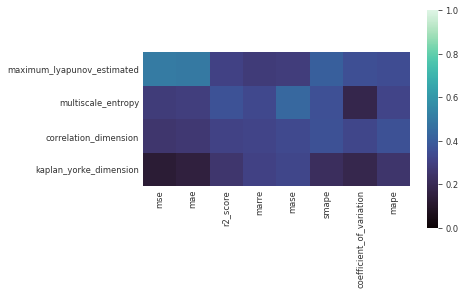

In [55]:
cross_corr = pd.concat([metrics_df, all_properties], axis=1, keys=['metrics_df', 'all_properties']).corr(method="spearman").loc['metrics_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds, metric_sort_inds], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/metric_math.png", dpi=600)

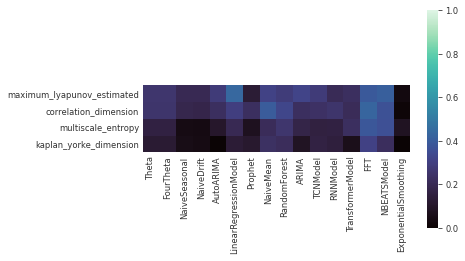

In [246]:
cross_corr = pd.concat([models_df, all_properties], axis=1, keys=['models_df', 'all_properties']).corr(method="spearman").loc['models_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds][df_models_sorted.columns], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

# dg.better_savefig("../private_writing/fig_resources/models_math_corr.png", dpi=600)

In [81]:

## Easiest and hardest systems
print("Easiest systems: ", np.unique(models_df.idxmin(axis=0), return_counts=True))
print("Hardest systems: ", np.unique(models_df.idxmax(axis=0), return_counts=True))


all_median_names = list()
for key in models_df.keys():
    all_median_names.append(models_df[models_df[key] == models_df[key].quantile(interpolation='nearest')].index[0])
    
print("Middle systems: ", np.unique(all_median_names, return_counts=True))

Easiest systems:  (array(['ArnoldWeb', 'StickSlipOscillator', 'Torus'], dtype=object), array([ 1,  5, 10]))
Hardest systems:  (array(['CellularNeuralNetwork', 'Chua', 'CoevolvingPredatorPrey',
       'DoublePendulum', 'HyperQi', 'LuChen', 'SprottTorus',
       'TurchinHanski'], dtype=object), array([2, 1, 2, 1, 2, 1, 6, 1]))
Middle systems:  (array(['ChenLee', 'Duffing', 'Finance', 'Halvorsen', 'HyperYan',
       'JerkCircuit', 'LorenzStenflo', 'OscillatingFlow', 'Rossler',
       'Rucklidge', 'SprottA', 'SprottF', 'SprottG', 'ThomasLabyrinth'],
      dtype='<U15'), array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]))


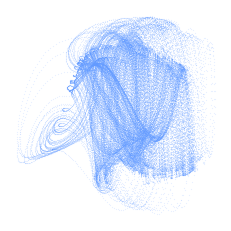

In [39]:
plt.figure()
sol = Hadley().make_trajectory(80000, resample=True, pts_per_period=100)
plt.plot(sol[:, 0], sol[:, 2], ".", color=dg.blue, markersize=0.1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
# dg.better_savefig("../private_writing/fig_resources/lorenz.png", dpi=600)


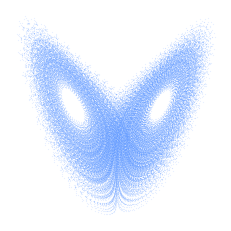

In [38]:
plt.figure()
sol = Lorenz().make_trajectory(80000, resample=True, pts_per_period=100)
plt.plot(sol[:, 0], sol[:, 2], ".", color=dg.blue, markersize=0.1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
# dg.better_savefig("../private_writing/fig_resources/lorenz.png", dpi=600)


/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:287: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


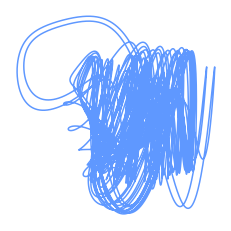

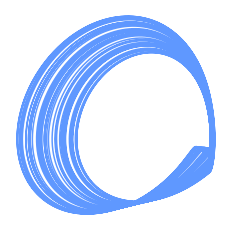

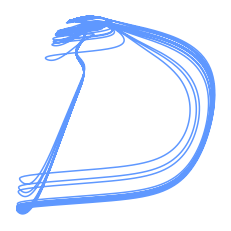

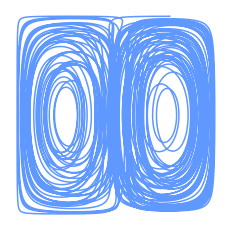

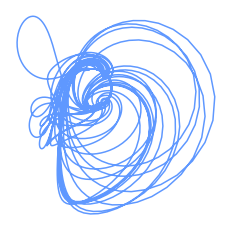

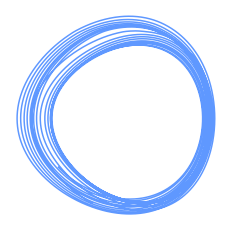

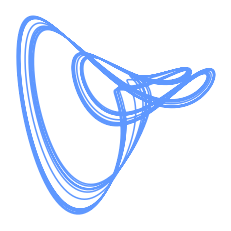

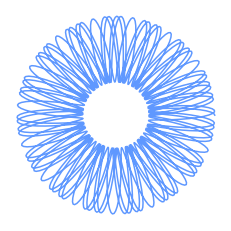

In [22]:
from dysts.flows import SprottTorus, StickSlipOscillator, Torus, SprottG

style1 = {"color": (0.4, 0.4, 0.4)}

style1 = {"color": dg.blue}

plt.figure()
sol = Hadley().make_trajectory(40000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/hadley2.png", dpi=600)

plt.figure()
sol = WindmiReduced().make_trajectory(20000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/windmi2.png", dpi=600)


plt.figure()
sol = HindmarshRose().make_trajectory(30000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/hindmarsh2.png", dpi=600)


plt.figure()
sol = DoubleGyre().make_trajectory(30000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/gyre2.png", dpi=600)

plt.figure()
sol = SprottTorus().make_trajectory(30000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/sprott_torus2.png", dpi=600)

plt.figure()
sol = StickSlipOscillator().make_trajectory(20000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/stickslip2.png", dpi=600)

plt.figure()
sol = SprottG().make_trajectory(10000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/sprottg2.png", dpi=600)

plt.figure()
sol = Torus().make_trajectory(2000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
dg.vanish_axes()
dg.better_savefig("../private_writing/fig_resources/torus2.png", dpi=600)

# Multivariate benchmarks

+ Added in 2023

In [48]:
import os
import json

GRANULARITY = 100

with open(
    os.getcwd()
    + "/results/results_neural_ode_multivariate.json",
    "r",
) as file:
    all_results2 = json.load(file)

with open(
    os.getcwd()
    + "/results/results_test_multivariate__pts_per_period_100__periods_12.json",
    "r",
) as file:
    all_results1 = json.load(file)

with open(os.getcwd() + "/results/results_esn_multivariate.json", "r") as file:
    all_results_esn = json.load(file)

all_scores = dict()
for key in all_results1.keys():
    if key not in all_results2.keys():
        continue
    all_scores[key] = dict()
    for model_name in all_results1[key].keys():
        if model_name == "values":
            continue
        all_scores[key][model_name] = all_results1[key][model_name]["smape"]
    all_scores[key]["nODE"] = all_results2[key]["smape"]

    all_scores[key]["ESN"] = all_results_esn[key]["smape"]


all_scores = pd.DataFrame(all_scores).transpose()
all_scores_dict = all_scores.to_dict()

print(all_scores.shape)

(131, 14)


NBEATSModel               56.462485
NHiTSModel                62.933582
RandomForest              70.518979
RNNModel                  71.045973
nODE                      75.584701
TransformerModel          77.053306
XGBModel                  86.580253
LinearRegressionModel     86.692339
ESN                       87.386959
NLinearModel              90.487595
DLinearModel              95.192333
BlockRNNModel            103.323261
TCNModel                 113.761830
KalmanForecaster         130.020557
dtype: float64

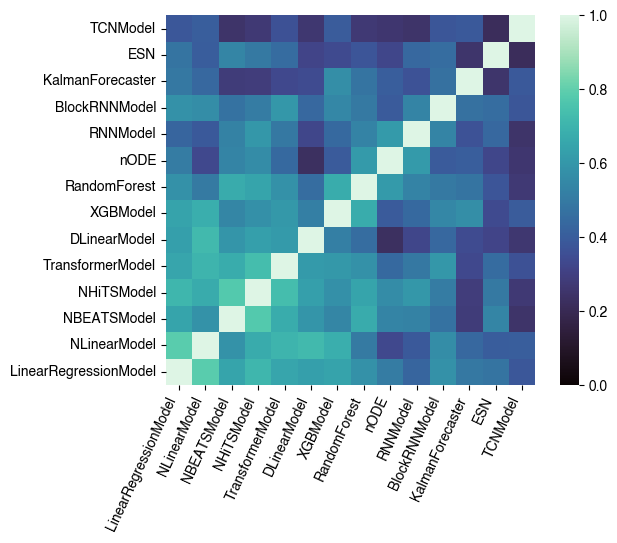

In [28]:
# plt.imshow(all_scores.corr(), vmin=0, vmax=1)
import seaborn as sns

## Sort the models by their correlation with the best model
corr_array = np.array(all_scores.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)
sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
all_scores = all_scores.iloc[:, sort_inds]
ax = sns.heatmap(all_scores.corr(method='spearman'), cmap="mako", vmin=0, vmax=1, square=True)
ax.invert_yaxis()
## tilt the x labels and center on tick
for item in ax.get_xticklabels():
    item.set_rotation(65)
    item.set_horizontalalignment("right")

# set font to helvetica
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')



# Best model on average
all_scores.mean(axis=0).sort_values()


In [33]:
all_scores["nODE"]

Aizawa                      85.637996
AnishchenkoAstakhov         31.939591
Arneodo                    125.728512
ArnoldBeltramiChildress    110.309632
ArnoldWeb                  165.872408
                              ...    
WangSun                    119.747451
WindmiReduced               85.983642
YuWang                     113.019848
YuWang2                     86.176173
ZhouChen                    96.507246
Name: nODE, Length: 131, dtype: float64

In [52]:
## Timing results

fpath = "./results/results_test_multivariate__pts_per_period_100__periods_12.json_timing.json"
with open(fpath, "r") as file:
    all_timings = json.load(file)

## invert inner and outer keys
timings = dict()
for model_name in all_timings["Aizawa"].keys():
    if model_name == "values":
        continue
    timings[model_name] = dict()
    for equation_name in all_timings:
        timings[model_name][equation_name] = all_timings[equation_name][model_name]






KeyError: 'TransformerModel'

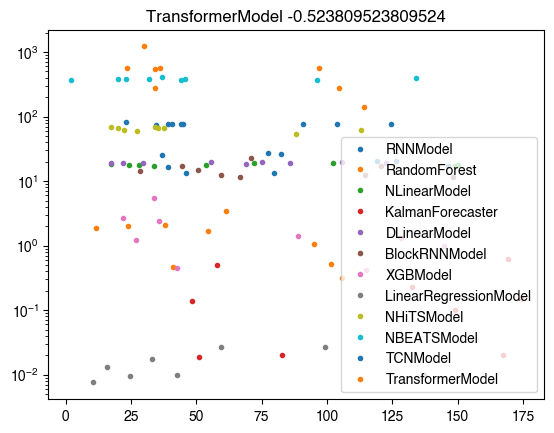

In [67]:

from scipy.stats import spearmanr
for model_name in timings:

    all_pairs = list()
    for equation_name in timings[model_name]:
        try:
            time_val = float(timings[model_name][equation_name]["Train time"])
            error_val = float(all_scores_dict[model_name][equation_name])
            all_pairs.append((time_val, error_val))
        except KeyError:
            continue
    all_pairs = np.array(all_pairs)
    # plt.figure()
    plt.semilogy(all_pairs[:, 1], all_pairs[:, 0], '.')
    plt.title(f"{model_name} {spearmanr(all_pairs[:, 0], all_pairs[:, 1])[0]}")

plt.legend(timings.keys())

Text(0.5, 1.0, 'Spearman correlation = 0.43')

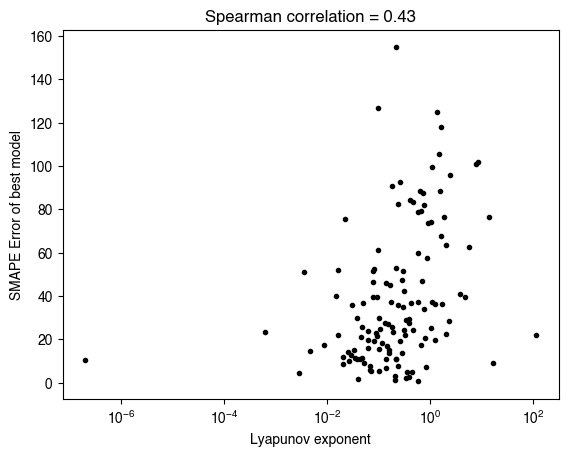

In [216]:
# best_scores = pd.DataFrame(all_scores["NBEATSModel"])
best_scores = pd.DataFrame(all_scores.min(axis=1).sort_values())
best_scores.columns = ["smape"]

# add column for lyapunov exponents
best_scores["lyapunov"] = np.nan * np.ones(best_scores.shape[0])

import dysts.flows as dfl

for equation_name in best_scores.index:
    eq = getattr(dfl, equation_name)()
    max_lyap = eq.maximum_lyapunov_estimated
    # score_val = all_results[equation_name]["smape"]
    best_scores.loc[equation_name, "lyapunov"] = max_lyap

plt.figure()
plt.semilogx(best_scores["lyapunov"], best_scores.iloc[:, 0], '.k')
plt.xlabel("Lyapunov exponent")
plt.ylabel("SMAPE Error of best model")

from scipy.stats import spearmanr
corr_val = spearmanr(best_scores["lyapunov"], best_scores.iloc[:, 0])[0]
plt.title(f"Spearman correlation = {corr_val:.2f}")


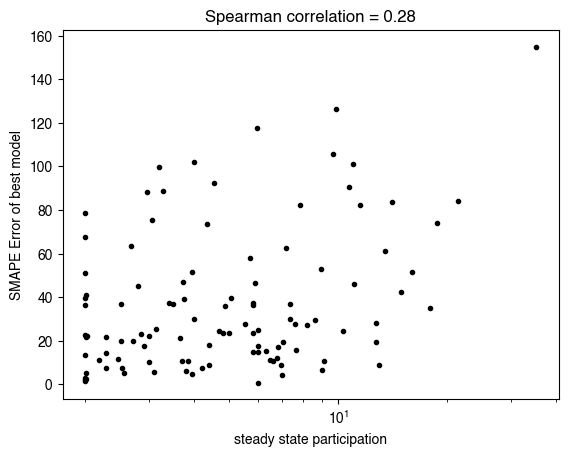

In [222]:
import pandas as pd
orbit_features = pd.read_csv("./resources/private_topo_features3.csv", index_col=0)

best_scores = pd.DataFrame(all_scores.min(axis=1).sort_values())
best_scores.columns = ["smape"]

## Merge the two dataframes
best_scores = orbit_features.merge(best_scores, left_index=True, right_index=True)
best_scores = best_scores.dropna()


for name in ['steady state participation']:

    plt.figure()
    plt.semilogx(best_scores[name], best_scores["smape"], '.k')
    plt.xlabel(name)
    plt.ylabel("SMAPE Error of best model")

    from scipy.stats import spearmanr
    corr_val = spearmanr(best_scores[name], best_scores["smape"])[0]
    plt.title(f"Spearman correlation = {corr_val:.2f}")

## Long forecast task

In [5]:
## Compute smape versus forecast horizon

import gzip

from dysts.metrics import smape
import dysts.flows as dfl
import json

## Load data from long forecasting task
# with open(
#     os.getcwd()
#     + "/results/results_test_multivariate__pts_per_period_100__periods_60.json",
#     "r",
# ) as file:
#     all_results = json.load(file)

## Load data from long forecasting task
fpath = os.getcwd() + "/results/results_test_multivariate__pts_per_period_100__periods_60.json.gz"
all_results = gzip.open(fpath, mode='r').read()
all_results = json.loads(all_results)

## Load and append neural ode results
fpath = os.getcwd() + "/results/results_neural_ode_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_node = gzip.open(fpath, mode='r').read()
all_results_node = json.loads(all_results_node)
for key in all_results.keys():
    if key not in all_results_node.keys():
        continue
    all_results[key]["NODEModel"] = dict()
    all_results[key]["NODEModel"]["prediction"] = all_results_node[key]["traj_pred"]
    all_results[key]["NODEModel"]["smape"] = all_results_node[key]["smape"]

## Load and append echo state network results
fpath = os.getcwd() + "/results/results_esn_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_esn = gzip.open(fpath, mode='r').read()
all_results_esn = json.loads(all_results_esn)
for key in all_results.keys():
    if key not in all_results_esn.keys():
        continue
    all_results[key]["ESNModel"] = dict()
    all_results[key]["ESNModel"]["prediction"] = all_results_esn[key]["traj_pred"]
    all_results[key]["ESNModel"]["smape"] = all_results_esn[key]["smape"]

In [10]:
## Compute smape versus forecast horizon

import gzip

from dysts.metrics import smape
import dysts.flows as dfl
import json

## Load data from long forecasting task
fpath = os.getcwd() + "/results/results_test_multivariate__pts_per_period_100__periods_60.json.gz"
all_results = gzip.open(fpath, mode='r').read()
all_results = json.loads(all_results)

## Load and append neural ode results
fpath = os.getcwd() + "/results/results_neural_ode_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_node = gzip.open(fpath, mode='r').read()
all_results_node = json.loads(all_results_node)
for key in all_results.keys():
    if key not in all_results_node.keys():
        continue
    all_results[key]["NODEModel"] = dict()
    all_results[key]["NODEModel"]["prediction"] = all_results_node[key]["traj_pred"]
    all_results[key]["NODEModel"]["smape"] = all_results_node[key]["smape"]

## Load and append echo state network results
fpath = os.getcwd() + "/results/results_esn_multivariate__pts_per_period_100__periods_60.json.gz"
all_results_esn = gzip.open(fpath, mode='r').read()
all_results_esn = json.loads(all_results_esn)
for key in all_results.keys():
    if key not in all_results_esn.keys():
        continue
    all_results[key]["ESNModel"] = dict()
    all_results[key]["ESNModel"]["prediction"] = all_results_esn[key]["traj_pred"]
    all_results[key]["ESNModel"]["smape"] = all_results_esn[key]["smape"]

all_outputs = dict()
for key in all_results:
    true_vals = np.array(all_results[key]["values"])
    all_traces = dict()
    for key2 in all_results[key]:
        if key2 == "values":
            continue

        pred_vals = np.array(all_results[key][key2]["prediction"])

        ## Some models fail to generate forecasts
        if np.any(pred_vals == None):
            continue
        
        ## probably need to exclude the maximum lookback window, since some models
        ## just learn a difference operator
        all_smapes = []
        for i in range(1, true_vals.shape[0]):
            true_vals_sub = true_vals[:i, :]
            pred_vals_sub = pred_vals[:i, :]
            smape_val = smape(true_vals_sub, pred_vals_sub)
            all_smapes.append(smape_val)
        all_traces[key2] = np.array(all_smapes)
    #all_traces = np.array(all_traces)
    all_outputs[key] = all_traces
    #all_outputs.append(all_traces)

    #all_outputs[key] = all_traces
    # all_output_scores[key] = dict()
    # all_output_scores[key]["mean"] = np.mean(all_traces, axis=0)
    # all_output_scores[key]["median"] = np.median(all_traces, axis=0)
    # all_output_scores[key]["min"] = np.min(all_traces, axis=0)

    # np.mean(np.array(all_traces), axis=0)
    # np.median(np.array(all_traces), axis=0)
    # np.min(np.array(all_traces), axis=0)


## Fetch all lyapunov exponents
all_lyaps = dict()
for equation_name in all_results.keys():
    eq = getattr(dfl, equation_name)()
    max_lyap = eq.maximum_lyapunov_estimated
    # score_val = all_results[equation_name]["smape"]
    all_lyaps[equation_name] = max_lyap
    

# save all outputs using json.dump and gzip
# save all outputs using json.dump
import json, gzip
with gzip.open('./resources/all_outputs_long_forecasting.json.gz', 'wt', encoding="utf-8") as file:
    all_output_list = dict()
    for key in all_outputs.keys():
        all_output_list[key] = dict()
        for key2 in all_outputs[key].keys():
            all_output_list[key][key2] = all_outputs[key][key2].tolist()
    #json.dump(all_output_list, file, indent=4)


print(f"{len(all_lyaps)} systems")


/Users/william/miniconda3/envs/dysts/lib/python3.10/site-packages/dysts/metrics.py:131: RuntimeWarning: invalid value encountered in true_divide
  return 100 * np.mean(np.abs(x - y) / (np.abs(x) + np.abs(y))) * 2


133 systems


In [11]:
import json, gzip
with gzip.open('./resources/all_outputs_long_forecasting.json.gz', 'wt', encoding="utf-8") as file:
    all_output_list = dict()
    for key in all_outputs.keys():
        all_output_list[key] = dict()
        for key2 in all_outputs[key].keys():
            all_output_list[key][key2] = all_outputs[key][key2].tolist()
    json.dump(all_output_list, file, indent=4)


print(f"{len(all_lyaps)} systems")

133 systems


In [12]:
## Load all outputs from cell above
import json, gzip
with gzip.open('./resources/all_outputs_long_forecasting.json.gz', 'rt', encoding="utf-8") as file:
    all_outputs = json.load(file)
    for key in all_outputs.keys():
        for key2 in all_outputs[key].keys():
            all_outputs[key][key2] = np.array(all_outputs[key][key2])

from scipy.stats import median_abs_deviation
all_smape_series = dict()
for model_name in all_outputs["Lorenz"].keys():
    all_smapes = []
    for equation_name in all_outputs.keys():
        if model_name not in all_outputs[equation_name].keys():
            print(f"skipping {model_name}")
            continue
        smape_val = all_outputs[equation_name][model_name]
        all_smapes.append(smape_val)
    all_smapes = np.array(all_smapes)

    all_smape_series[model_name] = dict()
    all_smape_series[model_name]["median"] = np.nanmedian(all_smapes, axis=0)
    all_smape_series[model_name]["p75"] = np.percentile(all_smapes, 75, axis=0)
    all_smape_series[model_name]["p25"] = np.percentile(all_smapes, 25, axis=0)
    all_smape_series[model_name]["mad"] = median_abs_deviation(all_smapes, axis=0)
    all_smape_series[model_name]["mean"] = np.nanmean(all_smapes, axis=0)
    all_smape_series[model_name]["stderr"] = np.nanstd(all_smapes, axis=0) / np.sqrt(all_smapes.shape[0])


skipping LinearRegressionModel


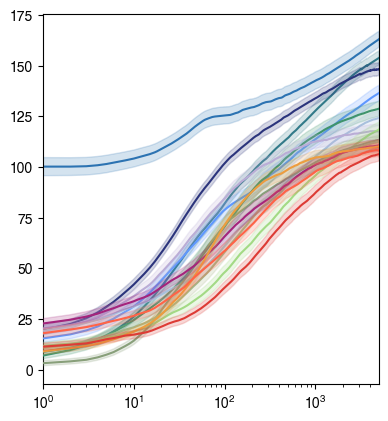

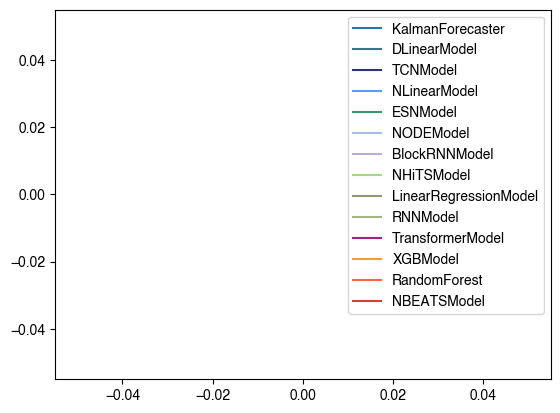

In [15]:

## rank all forecasting models in order of error
model_names = list(all_smape_series.keys())
all_smape_series_ranked = list()
for model_name in model_names:
    all_smape_series_ranked.append(all_smape_series[model_name]["mean"])
all_smape_series_ranked = np.array(all_smape_series_ranked)
all_smape_series_ranked = all_smape_series_ranked.argsort(axis=0).argsort(axis=0)
model_ranking = np.argsort(np.median(all_smape_series_ranked, axis=1))[::-1]
model_names = np.array(model_names)[model_ranking]

## Plot all models mean and errors
for i, model_name in enumerate(model_names):
    plt.fill_between(
        np.arange(all_smape_series[model_name]["mean"].shape[0]),
        all_smape_series[model_name]["mean"] - all_smape_series[model_name]["stderr"],
        all_smape_series[model_name]["mean"] + all_smape_series[model_name]["stderr"],
        color=pastel_rainbow[i],
        alpha=0.2,
        zorder=100*i
    )
    plt.semilogx(all_smape_series[model_name]["mean"], color=pastel_rainbow[i], zorder=100*i+1)

## Square aspect ratio with logaritmic x-axis
plt.gca().set_aspect(1.0 / plt.gca().get_data_ratio(), adjustable='box')
plt.gca().set_xscale("log")
## tight xlim bounds to avoid white space
plt.xlim(1, all_smape_series[model_name]["mean"].shape[0])
## save the figure
# plt.savefig(
#     f"../private_writing2/fig_resources/forecast_lengths_legend.png", 
#     dpi=300, 
#     bbox_inches="tight"
# )

## make a separate legend for the fill_between
plt.figure()
for i, model_name in enumerate(model_names):
    plt.plot([], color=pastel_rainbow[i], label=model_name)
plt.legend()
## save the figure
# plt.savefig(
#     f"../private_writing2/fig_resources/forecast_lengths_legend.png", 
#     dpi=300, 
#     bbox_inches="tight"
# )



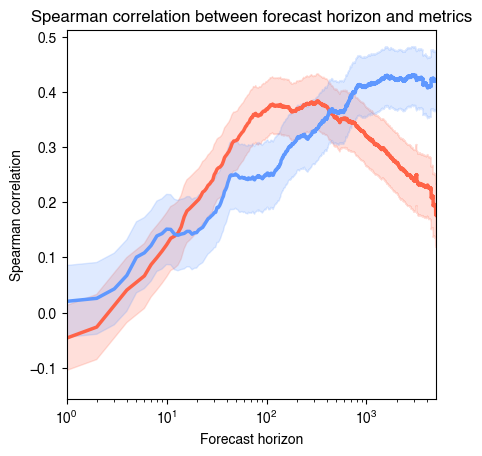

In [18]:
## try median aggregation as well

## aggregation across models
all_outputs_aggregated = dict()
for equation_name in all_results.keys():
    all_traces = list()
    for model_name in all_outputs[equation_name]:
        all_traces.append(all_outputs[equation_name][model_name])
    all_traces = np.array(all_traces)
    # all_traces = np.min(all_traces, axis=0)
    # all_traces = np.mean(all_traces, axis=0)
    all_traces = np.median(all_traces, axis=0)
    all_outputs_aggregated[equation_name] = all_traces


## Look up properties for each system and then correlate with the score
from scipy.stats import spearmanr
all_spearman = list()
for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
    all_spearman_sub, all_lyap_sub = list(), list()
    for equation_name in all_outputs_aggregated.keys():
        if equation_name not in all_lyaps.keys():
            continue
        lyap_val = all_lyaps[equation_name]
        score_val = all_outputs_aggregated[equation_name][i]
        all_spearman_sub.append(score_val)
        all_lyap_sub.append(lyap_val)
    corr_val = spearmanr(all_lyap_sub, all_spearman_sub)[0]
    all_spearman.append(corr_val)


## Look up properties for each system and then correlate with the score
import pandas as pd
from scipy.stats import spearmanr
orbit_features = pd.read_csv("./resources/private_topo_features3.csv", index_col=0)
orbit_features = orbit_features.transpose().to_dict()
## add lyapunov exponents
for equation_name in orbit_features:
    if equation_name in all_lyaps:
        orbit_features[equation_name]["lyapunov exponent"] = all_lyaps[equation_name]


plt.figure()
correlation_dict = dict()
# for metric_name in orbit_features["Aizawa"].keys():
for metric_name in ["lyapunov exponent", "steady state participation"]:

    all_spearman = list()
    all_spearman_std = list()
    for i in range(all_outputs_aggregated["Aizawa"].shape[-1]):
        all_spearman_sub, all_metric_sub = list(), list()
        for equation_name in all_outputs_aggregated.keys():
            if equation_name not in orbit_features.keys():
                continue
            metric_val = orbit_features[equation_name][metric_name]
            if np.isnan(metric_val):
                continue
            if metric_val == None:
                continue
            score_val = all_outputs_aggregated[equation_name][i]
            all_spearman_sub.append(score_val)
            all_metric_sub.append(metric_val)
        if len(all_spearman_sub) < int(0.7 * len(orbit_features)):
            print("Excessive missing values")
        corr_val = spearmanr(all_metric_sub, all_spearman_sub, nan_policy='omit')[0]
        all_spearman.append(corr_val)

        ## confidence interval via Fisher transformation 
        corr_err_up = np.tanh(np.arctanh(corr_val) + 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        corr_err_down = np.tanh(np.arctanh(corr_val) - 0.674 / np.sqrt(len(all_spearman_sub) - 3))
        all_spearman_std.append([corr_err_down, corr_err_up])

    all_spearman = np.array(all_spearman)
    all_spearman_std = np.array(all_spearman_std)
    correlation_dict[metric_name] = dict()
    correlation_dict[metric_name]["spearman"] = all_spearman
    correlation_dict[metric_name]["spearman interval"] = all_spearman_std

red = [1.0, 0.3882, 0.2784]
blue = [0.372549, 0.596078, 1]
colors = [red, blue]
for i, metric_name in enumerate(correlation_dict.keys()):
    all_spearman = correlation_dict[metric_name]["spearman"]
    all_sperr = correlation_dict[metric_name]["spearman interval"]
    plt.semilogx(all_spearman, color=colors[i], linewidth=2.5)
    plt.fill_between(
        np.arange(len(all_spearman)),
        all_sperr[:, 0],
        all_sperr[:, 1],
        alpha=0.2,
        color=colors[i]
    )

# plt.legend(correlation_dict.keys())
plt.xlim([1, len(all_spearman)])
plt.gca().set_aspect(1.0 / plt.gca().get_data_ratio(), adjustable='box')
plt.gca().set_xscale("log")

plt.xlabel("Forecast horizon")
plt.ylabel("Spearman correlation")
plt.title(f"Spearman correlation between forecast horizon and metrics")
plt.savefig(
    f"../private_writing2/fig_resources/forecast_horizon_correlation.png", 
    dpi=300, 
    bbox_inches="tight"
)




